# Annotating EEG

This notebook attempts to annotate EEG data with events derived from watching the videos of either VR or real-world trials. 
This notebook assumes that you have:

1. Aligned the video and EEG data using the `align_video_eeg.ipynb` notebook script already.
2. Provided a `.csv` file detailing manual annotations of events in the video. The `.csv` file should contain the following headers: 
    1. `timestamp`: The timestamp (in MM:SS.FFF format). Relative to the start of the raw, unspliced video.
    2. `timestamp_seconds`: The converted timestamps in `timestamp` from MM:SS.FFF to SS.FFF
    3. `timestamp_milliseconds`: The converted timestamps from SS.FFF to pure milliseconds.
    4. `trial_milliseconds`: The timestamps from `timestamp_milliseconds` made relative to the trial start (aka when the countdown ends).
    5. `player_action`: A label to describe what action the player has taken in this moment. More below.
    6. `direction`: Another label that is more general than `player_action`.
    7. `scene_description`: A short description that describes the scene context as a rationale for the `player_action`.
    
Referring specifically to `player_action` and `direction` in the provided event data, note that we're expecting particular vernacular.

* `player_action`:
    * `Walk`: The player makes an active movement.
    * `Slow`: Same as `Walk`, except that the movement appears to be slower than their expected movement speed.
    * `Stop`: The player makes an active full stop regardless of direction.
    * `Shift`: the player makes a translation not in the same direction as the current trajectory.
    * `Rotate`: The player adjusts their orientation directly.
    * `Continue`: A meaningless descriptor to just indicate that they're continuing in the current trajectory.
* `direction`: 
    * `Forward`: Forward relative to the street orientation.
    * `Left`: Leftward relative to the street orientation.
    * `Right`: Rightward relative to the street orientation.

## Import Packages

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

## Read EEG

In [2]:
def read_eeg(src:str, print_debug:bool=False):    
    # Read the EEG file
    if print_debug: print("Reading SRC csv file...")
    df = pd.read_csv(src)
    
    # Return the processed dataframe
    if print_debug: print("Reading EEG successful!")
    return df

In [3]:
eeg_df = read_eeg('./samples/eeg.csv')
eeg_df.head()

,Unnamed: 0,TimeStamp,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,Theta_AF8,Theta_TP10,...,HeadBandOn,HSI_TP9,HSI_AF7,HSI_AF8,HSI_TP10,Battery,Elements,unix_ms,rel_unix_ms,trial_ms
0,11,2024-11-24 12:53:58.722,1.246195,0.415802,0.847750,1.586403,0.499165,0.049713,0.222488,1.680369,...,1.0,1.0,1.0,1.0,1.0,60.0,NaN,1732470838722,4001,0
1,12,2024-11-24 12:53:59.221,0.930701,0.469915,0.717394,1.586403,0.424654,0.105200,0.073327,1.680369,...,1.0,1.0,1.0,1.0,1.0,60.0,NaN,1732470839221,4500,499
2,14,2024-11-24 12:53:59.726,0.614851,0.492273,0.506193,1.586403,0.415773,0.223576,0.049880,1.680369,...,1.0,1.0,1.0,1.0,1.0,60.0,NaN,1732470839726,5005,1004
3,15,2024-11-24 12:54:00.222,0.486586,0.530584,0.367788,1.586403,0.147880,0.259888,0.224948,1.680369,...,1.0,1.0,1.0,1.0,1.0,60.0,NaN,1732470840222,5501,1500
4,17,2024-11-24 12:54:00.722,0.486586,0.623767,0.688515,1.586403,0.147880,0.379940,0.493388,1.680369,...,1.0,1.0,1.0,1.0,1.0,60.0,NaN,1732470840722,6001,2000


## Read Events

In [4]:
def read_events(src:str, print_debug:bool=False):
    events_df = pd.read_csv(src)
    return events_df

In [5]:
events_df = read_events('./samples/events.csv')
events_df.head()

,timestamp,timestamp_sec,timestamp_ms,trial_ms,player_action,direction,scene_description
0,01:10.000,70.00,70000,310,Walk,Forward,Trial start. Incoming pedestrian on immediate ...
1,01:21.100,81.10,81100,11410,Shift,Left,Pedestrian on immediate right from behind. Par...
2,01:29.430,89.43,89430,19740,Shift,Left,Incoming pedestrian walking to right of partic...
3,01:31.700,91.70,91700,22010,Shift,Right,Pedestrian passes participant on right. Incomi...
4,01:34.970,94.97,94970,25280,Walk,Forward,Pedestrian on left passes participant. Partici...


## Normalizing to Concentration Median or Mean

Because everyone's data is a bit different, we need to normalize the data on a per-participant basis to some qualitative baseline. In this case, this is why we measured the EEG data of both their rest state and concentration state. It's just a matter of ratio-ing the data to be normalized to the data of our choice...

* I think it's prudent to analyze the data such that we normalize to their resting state. It's very reliable, because it's truly the baseline EEG value of their condition on that day.
* It's also prudent that we analyze the data based on their concentration level. That way, we also can (relatively) determine and measure eeg strength with respect to their default concentration level.

Both ways are viable, I think. Let's try to do both.

---

To start, we need reference EEG data. Let's look at our sample participant's data - P11. P11 has their rest and concentration state data in four kinds of data - rest without HMD, rest with HMD, 2D red ball, and 3D red ball.

## Annotating EEG with Events

This is where the unique stuff comes into play. Basically, we have two sets of data: the eeg data, and the events data. Both have timestamps. Both have been trimmed already, so all that's important is identifying key events in the eeg data that correspond to event timestamps.

For now, we follow these assumptions:

* TP9 and TP10 data are too knackered to really be useful. Let's focus purely at AF7 and AF8 data.
* We consider shifts and rotations to be separate events. Rotations, which are related to orientation, are different from shifts, which are purely translational.

In [10]:
frequency_colors = {
    'Delta':'red',
    'Theta':'purple',
    'Alpha':'skyblue',
    'Beta':'green',
    'Gamma':'orange'
}

direction_colors = {
    'Forward':'black',
    'Left':'red',
    'Right':'blue'
}

def annotate_eeg(
        eeg_df, 
        events_df, 
        frequency_channels=['Delta','Theta','Alpha','Beta','Gamma'], 
        electrode_channels=['AF7','AF8','TP9','TP10']):
    
    # Define the figure, number of rows, and number of columns
    figure = plt.figure(figsize=(15,15))
    nrows = len(frequency_channels)
    ncols = len(electrode_channels)
    
    # Generate the subplots for the figure. Keep a reference to each axis via a list
    axi = 1
    axes = []
    for fi in range(len(frequency_channels)):
        freq = frequency_channels[fi]
        row_freq_ax = plt.subplot(nrows, ncols, axi)
        freq_color = frequency_colors[freq]
        
        for ei in range(len(electrode_channels)):
            elec = electrode_channels[ei]
            colname = f'{freq}_{elec}'
            
            if ei == 0: ax = plt.subplot(nrows, ncols, axi)
            else: ax = plt.subplot(nrows, ncols, axi, sharey=row_freq_ax)
            eeg_df.plot(x='trial_ms', y=colname, ax=ax, title=colname, c=freq_color)
            ax.axhline(y=0, c='gray', linewidth=1, alpha=0.2)
            axes.append(ax)
            
            axi += 1
    
    # Iterate through list of known events. Events are designated as vertical lines, with buffer of 2s per event.
    for index, row in events_df.iterrows():
        line_color = direction_colors[row['direction']]
        for ax in axes:
            ax.axvline(x=row['trial_ms'], c=line_color, linewidth=1, zorder=0)
    
    plt.tight_layout()
    plt.show()

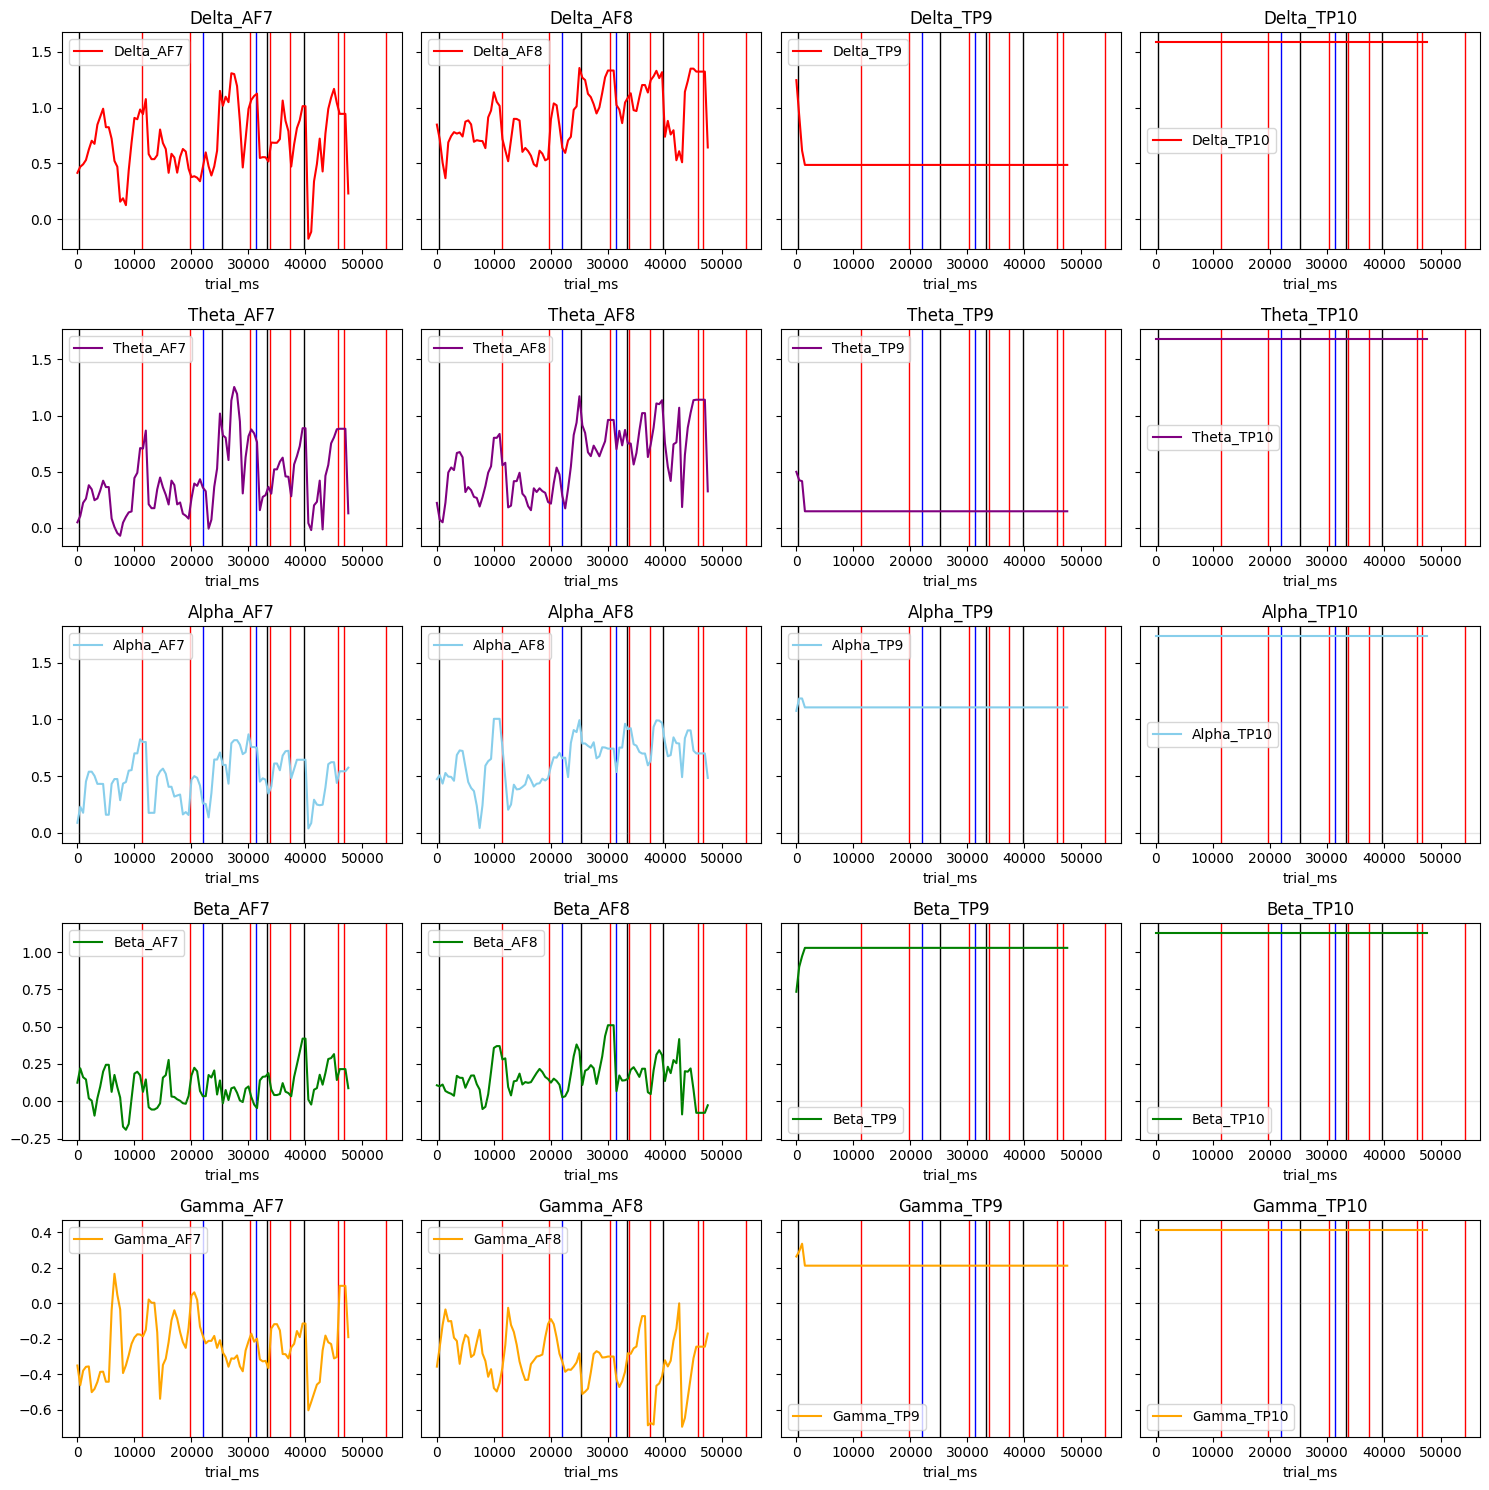

In [12]:
annotate_eeg(eeg_df, events_df, electrode_channels=['AF7','AF8','TP9','TP10'])

## Extracting EEG Clips

The idea now is that we can begin to extract clips of EEG data. We dichotemize between EEG frequency band and electrode channel.

We ideally want to extract two seconds before and two seconds after. This is because we want to identify if there's a way to either __predict__ or __identify__ movements, with two different schools of thought trying to argue it's possible. Either way, we need to extract them.

The most optimal way I find we can extract is to 